# Оптимизация гиперпараметров модели

B машинном обучении есть два типа параметров:

**Внутренние (параметры модели)**

Подбираются во время обучения и определяют, как использовать входные данные для получения необходимого результата.

Например, это веса (коэффициенты уравнения) в линейной/логистической регрессии.

**Внешние (параметры алгоритма)**

Их принято называть **гиперпараметрами**. Внешние параметры могут быть произвольно установлены перед началом обучения и контролируют внутреннюю работу обучающего алгоритма.

Например, это параметр регуляризации в линейной/логистической регрессии.

**Гиперпараметры** отвечают за сложность взаимосвязи между входными признаками и целевой переменной, поэтому сильно влияют на модель и качество прогнозирования.

Продемонстрируем это на примере задачи **регрессии** с помощью двух графиков работы алгоритма случайного леса, построенного на основе 5, 100 деревьев (n_estimators = [5, 100]):

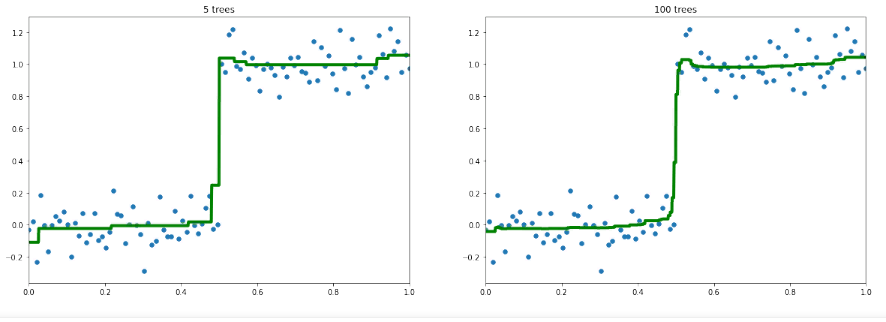

Видим, что при 100 деревьях модель находит более сложную закономерность в данных и точность соответственно будет выше, чем при 5.

Каждый алгоритм МО имеет набор гиперпараметров, которые определяют, как именно он строит модель на обучающей выборке. Например, в модуле ML-2 для повышения эффективности модели мы уже рассматривали подбор параметра регуляризации $a$ для алгоритма линейной регрессии Ridge.

Код:

In [3]:
import numpy as np # для матричных вычислений
import pandas as pd # для анализа и предобработки данных
import matplotlib.pyplot as plt # для визуализации
import seaborn as sns # для визуализации

from sklearn import linear_model # линейные модели
from sklearn import metrics # метрики
from sklearn import preprocessing # предобработка
from sklearn.model_selection import train_test_split # сплитование выборки
%matplotlib inline
plt.style.use('seaborn')

C:\Users\Lida\AppData\Local\Temp\ipykernel_6604\2869515752.py:11: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [10]:
data = pd.read_csv('data/insurance.zip')
data.head(3)

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.90,0,yes,southwest,16884.9240
1,18,male,33.77,1,no,southeast,1725.5523
2,28,male,33.00,3,no,southeast,4449.4620


In [11]:
# кодируем бинарные категориальные признаки
data['smoker'] = data['smoker'].apply(lambda x: 0 if x == 'no' else 1)
data['sex'] = data['sex'].apply(lambda x: 0 if x == 'female' else 1)
# оставшиеся категориальные признаки кодируем с помощью OneHot
data = pd.get_dummies(data)
data.head(3)

,age,sex,bmi,children,smoker,charges,region_northeast,region_northwest,region_southeast,region_southwest
0,19,0,27.90,0,1,16884.9240,0,0,0,1
1,18,1,33.77,1,0,1725.5523,0,0,1,0
2,28,1,33.00,3,0,4449.4620,0,0,1,0


In [12]:
features = data.drop('charges', axis=1).columns
X, y = data[features], data['charges']

In [13]:
# Создаем тренировочную и тестовую выборки с помощью train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, # таблица с наблюдениями и столбец с правильным ответами
    test_size=0.2, # размер тестовой выборки
    random_state=42 # число отвечающее за генерацию случайных чисел
)
# Выводим размеры полученных выборок
print('Train shape: {}'.format(X_train.shape))
print('Test shape: {}'.format(X_test.shape))

Train shape: (1070, 9)
Test shape: (268, 9)


In [14]:
# Инициализируем стандартизатор StandardScaler
scaler = preprocessing.StandardScaler()
# Подгоняем параметры стандартизатора (вычисляем среднее и СКО)
scaler.fit(X_train)
# Производим стандартизацию тренировочной выборки
X_train_scaled = scaler.transform(X_train)
# Производим стандартизацию тестовой выборки
X_test_scaled = scaler.transform(X_test)

# Создаём генератор полиномиальных признаков
poly = preprocessing.PolynomialFeatures(degree=2, include_bias=False)
poly.fit(X_train_scaled)
# Генерируем полиномиальные признаки для тренировочной выборки
X_train_scaled_poly = poly.transform(X_train_scaled)
# Генерируем полиномиальные признаки для тестовой выборки
X_test_scaled_poly = poly.transform(X_test_scaled)

# Выводим результирующие размерности таблиц
print(X_train_scaled_poly.shape)
print(X_test_scaled_poly.shape)

(1070, 54)
(268, 54)


In [15]:
y_train_log = np.log(y_train)

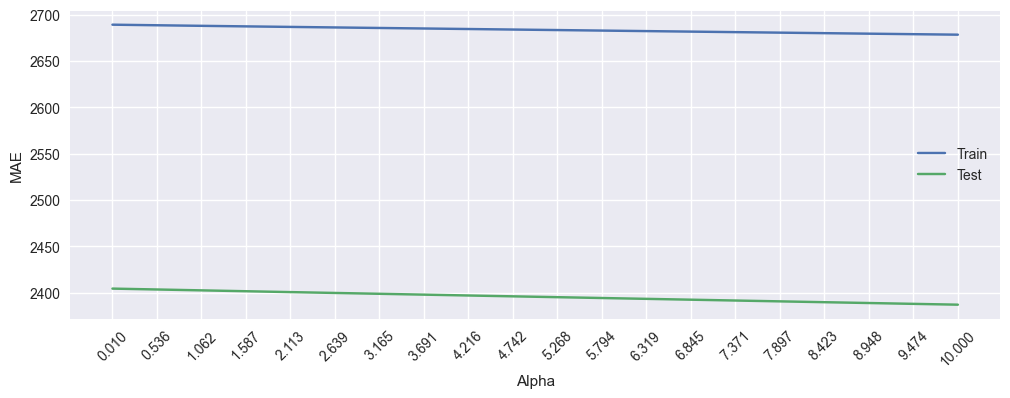

In [16]:
# Создаем список из 20 возможных значений от 0.001 до 10
alpha_list = np.linspace(0.01, 10, 20)
# Создаем пустые списки, в которые будем добавлять результаты
train_scores = []
test_scores = []
for alpha in alpha_list:
    # Создаем объект класса линейная регрессия с L2-регуляризацией
    ridge_lr_poly = linear_model.Ridge(alpha=alpha, max_iter=10000)
    # Обучаем модель предсказывать логарифм целевого признака
    ridge_lr_poly.fit(X_train_scaled_poly, y_train_log)
    #Делаем предсказание для каждой из выборок
    #Если обучили на логарифме, то от результата необходимо взять обратную функцию - экспоненту
    y_train_predict_poly = np.exp(ridge_lr_poly.predict(X_train_scaled_poly))
    y_test_predict_poly = np.exp(ridge_lr_poly.predict(X_test_scaled_poly))
    # Рассчитываем метрику для двух выборок и добавляем их в списки
    train_scores.append(metrics.mean_absolute_error(y_train, y_train_predict_poly))
    test_scores.append(metrics.mean_absolute_error(y_test, y_test_predict_poly))

# Визуализируем изменение R^2 в зависимости от alpha
fig, ax = plt.subplots(figsize=(12, 4)) #фигура + координатная плоскость
ax.plot(alpha_list, train_scores, label='Train') #линейный график для тренировочной выборки
ax.plot(alpha_list, test_scores, label='Test') #линейный график для тестовой выборки
ax.set_xlabel('Alpha') #название оси абсцисс
ax.set_ylabel('MAE') #название оси ординат
ax.set_xticks(alpha_list) #метки по оси абцисс
ax.xaxis.set_tick_params(rotation=45) #поворот меток на оси абсцисс
ax.legend(); #отображение легенды

Mожно попробовать перебрать значения $alpha < 0.01$.

В данном случае мы просто воспользовались циклом for и перебрали некоторые заданные значения alpha, хотя, по всей видимости, не самые оптимальные. Поэтому подобранные эмпирическим путём значения гиперпараметров с большей вероятностью дадут низкую прогностическую эффективность.

Также рассмотренный метод визуализации зависимости метрики от гиперпараметра позволяет выбрать только один внешний параметр, в данном случае — alpha. А что делать, если у нас не один, а несколько? 

Например, вспомним основные внешние параметры DecisionTreeClassifier:

* **criterion** — критерий информативности. Может быть равен 'gini' — критерий Джини — и 'entropy' — энтропия Шеннона.
* **max_depth** — максимальная глубина дерева. По умолчанию None, глубина дерева не ограничена.
* **max_features** — максимальное число признаков, по которым ищется лучшее разбиение в дереве. По умолчанию None, то есть обучение производится на всех признаках.
* **min_samples_leaf** — минимальное число объектов в листе. По умолчанию — 1.

Мы, конечно, можем сделать кучу вложенных циклов. Однако, поскольку поиск оптимальных значений гиперпараметров является общераспространенной задачей МО, библиотека scikit-learn и другие предлагают методы, позволяющие её решить.

Тщательный подбор гиперпараметров гарантирует, что модель покажет максимально возможную точность на обучающих данных, но это совершенно не означает хороший результат на тестовых или новых данных.

Поиск оптимальных значений гиперпараметров модели является сложной задачей, обязательной почти для всех моделей и наборов данных. Однако важно понимать смысл гиперпараметров перед их подбором.

## Базовые способы оптимизации гиперпараметров (GridSearchCV, RandomSearchCV)

## Продвинутые способамы оптимизации (Hyperopt, Optuna).

## 